In [1]:
import numpy as np
from torch import nn

In [2]:
import copy

In [3]:
class CliffWalkingEnv:
    """Waling in Cliff environment."""
    def __init__(self, ncol=12, nrow=4):
        self.ncol, self.nrow = ncol, nrow
        # transition matrix, [(p, next_state, reward, done)]
        self.P = self.createP()
    
    def createP(self):
        # 4 actions for every position with total self.nrow * self.ncol blocks
        P = [[[] for j in range(4)] for i in range(self.nrow * self.ncol)]
        #  rewards in the direction of up, down, left, right. (0, 0) at the top left position.
        #  this change is used to step up, down, left, right. e.g [0, -1] + current position
        #  it causes col - 1, 
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        for i in range(self.nrow):
            for j in range(self.ncol):
                for act in range(4):
                    # target or cliff postion-> reward = 0
                    # target: (self.nrow - 1, 0). cliff: (self.nrow - 1, j > 0)
                    # current position 
                    if i == self.nrow - 1 and j > 0:
                        # probability 1, next state, reward = 0, done
                        P[i * self.ncol + j][act] = [(1, i *self.ncol +j, 0, True)]
                        continue
                    next_x = min(self.ncol - 1, max(0, j + change[act][0]))
                    next_y = min(self.nrow - 1, max(0, i - change[act][1]))
                    next_state = next_y * self.ncol + next_x
                    reward = -1 
                    done = False 
                    # cliff or target position for next state
                    if next_y == self.nrow - 1 and next_x > 0:
                        done = True 
                        if next_x != self.ncol - 1: # this is target position
                            reward = -100
                    P[i * self.ncol + j][act] = [(1, next_state, reward, done)] 
        return P
                    

In [40]:
class PolicyIteration:
    """iteration to improve the policy"""
    def __init__(self, env, theta, gamma):
        self.env = env 
        self.v = [0] * self.env.ncol * self.env.nrow
        self.pi = [[0.25, 0.25, 0.25, 0.25] for i in range(self.env.ncol * self.env.nrow)]
        self.theta = theta # convergence val
        self.gamma = gamma
        
    def policy_evaluation(self):
        cnt = 1
        while True:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s  in range(self.env.ncol * self.env.nrow):
                qsa_list = [] # Q(s, a)
                for act in range(4):
                    qsa = 0
                    for res in self.env.P[s][act]:
                        p, next_s, r, done = res
                        qsa += p * (r + self.gamma * self.v[next_s] * (1 - done)) # done: 0, else 1
                    # transition p and Q(s,a): Q * p(s' | s)
                    qsa_list.append(self.pi[s][act] * qsa) 
                new_v[s] = sum(qsa_list)
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v
            if max_diff < self.theta: break
            cnt += 1
            print('iteration: ', cnt, end=' ')
        print()
        print(f"After {cnt} iterations, max diff is {max_diff}")
        
    def policy_improvement(self):
        for s in range(self.env.ncol * self.env.nrow):
            qsa_list = []
            for a in range(4):
                qsa = 0 # Q(s, a)
                for res in self.env.P[s][a]:
                    p, next_state, r, done = res
                    print("state value: ", self.v[next_state])
                    qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                qsa_list.append(qsa)
            maxq = max(qsa_list)
            cntq = qsa_list.count(maxq)
            # average
            self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
        print("update policy")
        return self.pi
    
    
    def policy_iteration(self):
        while True:
            self.policy_evaluation()
            old_pi = copy.deepcopy(self.pi)
            new_pi= self.policy_improvement()
            if old_pi == new_pi: break 
            
        

In [11]:
def print_agent(agent, actions=('^', 'v', '<', '>'), disaster=[], end=[]):
    """
    
    Args:
        agent: 
        actions:  defined actions, e.g. [0, 1, 2], ['^', 'v', '<', '>']
        disaster:  exceptions
        end: exceptions

    Returns:

    """
    print("state value:")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            print("%6.6s" % ("%.3f" % agent.v[i * agent.env.ncol +j]), end = ' ')
            
    print("policy: ")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # exceptions 
            if (i * agent.env.ncol + j) in disaster:
                print('****', end = ' ')
            elif (i * agent.env.ncol + j) in end:
                print('EEEE', end = ' ')
            else:
                a = agent.pi[i * agent.env.ncol + j]
                pi_str = ''
                for k in range(len(actions)):
                    pi_str += actions[k] if a[k] > 0 else 'o'
                print(pi_str, end = ' ')
        print()
    

In [7]:
env = CliffWalkingEnv()

In [22]:
theta = 0.01
gamma = 0.9


In [41]:
agent = PolicyIteration(env, theta, gamma)

In [24]:
env.P[0]


[[(1, 12, -1, False)],
 [(1, 0, -1, False)],
 [(1, 0, -1, False)],
 [(1, 1, -1, False)]]

In [42]:
agent.policy_evaluation()

iteration:  2 iteration:  3 iteration:  4 iteration:  5 iteration:  6 iteration:  7 iteration:  8 iteration:  9 iteration:  10 iteration:  11 iteration:  12 iteration:  13 iteration:  14 iteration:  15 iteration:  16 iteration:  17 iteration:  18 iteration:  19 iteration:  20 iteration:  21 iteration:  22 iteration:  23 iteration:  24 iteration:  25 iteration:  26 iteration:  27 iteration:  28 iteration:  29 iteration:  30 iteration:  31 iteration:  32 iteration:  33 iteration:  34 iteration:  35 iteration:  36 iteration:  37 iteration:  38 iteration:  39 iteration:  40 iteration:  41 iteration:  42 iteration:  43 iteration:  44 iteration:  45 
After 45 iterations, max diff is 0.008819477606465398


In [43]:
actions = ('^', 'v', '<', '>')
print_agent(agent, actions, list(range(37, 47)), [47])

state value:
-27.19 -28.46 -29.58 -30.26 -30.59 -30.67 -30.53 -30.11 -29.18 -27.44 -24.61 -21.41 -33.59 -36.85 -38.76 -39.65 -40.01 -40.10 -39.98 -39.56 -38.56 -36.30 -31.50 -23.31 -47.24 -58.56 -61.76 -62.75 -63.08 -63.15 -63.07 -62.77 -61.91 -59.40 -51.37 -22.97 -66.14  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 policy: 
^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> 
^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> 
^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> ^v<> 
^v<> **** **** **** **** **** **** **** **** **** **** EEEE 


In [45]:
class ValueIteration:
    """
    Value iteration
    """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow
        self.theta = theta 
        self.gamma = gamma
        # policy
        self.pi = [None for i in range(self.env.nrow * self.env.ncol)]
        
    def value_iteration(self):
        cnt = 0
        while True:
            max_diff = 0
            # initial status value
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = [] # Q(s, a)
                for a in range(4):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        p, next_state, r, done = res
                        qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                    qsa_list.append(qsa) # this is different from Policy Iteration
                new_v[s] = max(qsa_list)
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v 
            if max_diff < self.theta: break
            cnt += 1 
        print("Value iteration %s cycle" % cnt)
        self.get_policy()
        
    def get_policy(self):
        for s in range(self.env.ncol * self.env.nrow):
            qsa_list = []
            for a in range(4):
                qsa = 0
                for res in self.env.P[s][a]:
                    p, next_state, r, done = res
                    qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                qsa_list.append(qsa)
                maxq = max(qsa_list)
                cntq = qsa_list.count(maxq) 
                # average 
                self.pi[s] = [1 / cntq if q == maxq else 0 for q in qsa_list]
                
            
            

In [47]:
agent_2 = ValueIteration(env, theta, gamma)

In [48]:
agent_2.value_iteration()

Value iteration 14 cycle


In [49]:
print_agent(agent_2, actions, list(range(37, 47)), [47])

state value:
-7.712 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -7.458 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -7.176 -6.862 -6.513 -6.126 -5.695 -5.217 -4.686 -4.095 -3.439 -2.710 -1.900 -1.000 -7.458  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000 policy: 
^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^ooo 
^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^oo> ^ooo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ^ooo 
ovoo **** **** **** **** **** **** **** **** **** **** EEEE 


In [62]:
import gym
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
# pacman -Sy python-pyvirtualdisplay
# pip install pygame 
from IPython import display

In [75]:

env_frozenlake0 = gym.make('FrozenLake-v1', render_mode='rgb_array')
env_frozenlake0.reset()

(0, {'prob': 1})

In [76]:
env_frozenlake0 = env_frozenlake0.unwrapped

In [77]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("Step %d %s" % (step, info))
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())

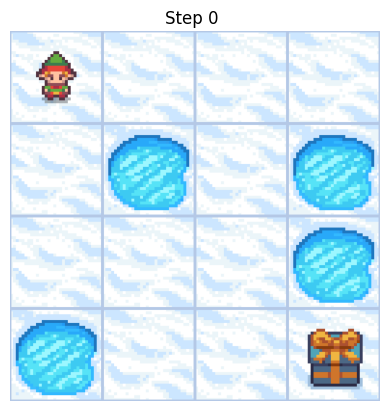

In [79]:
show_state(env_frozenlake0)

In [85]:
holes = set()

In [86]:
ends = set()

In [87]:
for s in env_frozenlake0.P:
    for a in env_frozenlake0.P[s]:
        for s_ in env_frozenlake0.P[s][a]:
            if s_[2] == 1.0: # target, final position 
                ends.add(s_[1])
            if s_[3] == True:
                holes.add(s_[1])


In [88]:
holes

{5, 7, 11, 12, 15}

In [89]:
ends

{15}

In [90]:
holes = holes - ends # this removes ends from holes
print('Hole index: ', holes)
print("Target index: ", ends)

for a in env_frozenlake0.P[14]:
    print(env_frozenlake0.P[14][a])

Hole index:  {11, 12, 5, 7}
Target index:  {15}
[(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False)]
[(0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True)]
[(0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False)]
[(0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False)]


In [91]:
for a in env_frozenlake0.P[14]:
    print(a)

0
1
2
3


In [92]:
actions

('^', 'v', '<', '>')

In [93]:
theta = 1e-5
gamma = 0.9
agent = PolicyIteration(env_frozenlake0, theta, gamma)
agent.policy_iteration()
print_agent(agent, actions, [5, 7, 11, 12], [15])

iteration:  2 iteration:  3 iteration:  4 iteration:  5 iteration:  6 iteration:  7 iteration:  8 iteration:  9 iteration:  10 iteration:  11 iteration:  12 iteration:  13 iteration:  14 iteration:  15 iteration:  16 iteration:  17 iteration:  18 iteration:  19 iteration:  20 iteration:  21 iteration:  22 iteration:  23 iteration:  24 iteration:  25 
After 25 iterations, max diff is 9.727246192441606e-06
state value:  0.00444902630020078
state value:  0.00444902630020078
state value:  0.006705089770241343
state value:  0.00444902630020078
state value:  0.006705089770241343
state value:  0.004202515082223095
state value:  0.006705089770241343
state value:  0.004202515082223095
state value:  0.00444902630020078
state value:  0.004202515082223095
state value:  0.00444902630020078
state value:  0.00444902630020078
state value:  0.004202515082223095
state value:  0.00444902630020078
state value:  0.0
state value:  0.00444902630020078
state value:  0.0
state value:  0.010049027274031766
stat

In [94]:
from tqdm import tqdm 

In [111]:
class CliffWalkingEnv2:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0
        self.y = self.nrow - 1 
        
    def step(self, action):
        # four actions: ^, v, <, >
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]] # [delta x, delta y
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1 # important !
        done = False
        if self.y == self.nrow - 1 and self.x > 0: # cliff or target
            done = True 
            if self.x != self.ncol -1:
                reward = -100 # cliff 
        return next_state, reward, done
    
    def reset(self):
        self.x = 0
        self.y = self.nrow - 1  # ?? not 0?? 
        return self.y * self.ncol + self.x
    
    
    
    

In [96]:
class Sarsa:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action = 4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
    def take_action(self, state):
        # choose next action, epsilon-greedy
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action 
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error 
        
        

In [97]:
ncol = 12 
nrow = 4

In [113]:
env = CliffWalkingEnv2(ncol, nrow)

In [114]:
np.random.seed(0)
epsilon = 0.1 
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500 

In [115]:
return_list = []

Iteration 9:  10%|█         | 5/50 [00:00<00:00, 371.16it/s, episode=500, return=-16.000]


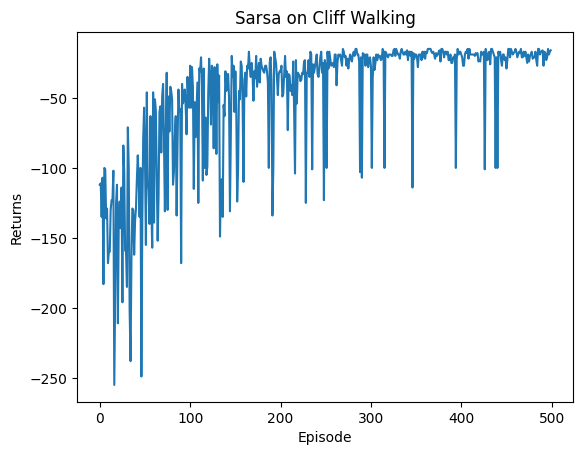

In [116]:
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)): # every process bar 
            episode_return = 0
            # initial position (state)
            # a random action
            state = env.reset()
            action = agent.take_action(state)
            done = False 
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode' : '%d' % (num_episodes / 10 * i + i_episode + 1), 'return' : '%.3f' % np.mean(return_list[-10])})
                pbar.update(1)
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episode')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [117]:
def print_agent(agent, env, action_meanings, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end = ' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end = ' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meanings)):
                    pi_str += action_meanings[k] if a[k] > 0 else 'o'
                print(pi_str, end = ' ')
        print()


In [118]:
action_meaning = ['^', 'v', '<', '>']
print_agent(agent, env, action_meaning, list(range(37, 47)), [47]) # target 47

ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [119]:
class nstep_Sarsa:
    """
    Sarsa implementation based on Sarsa algorithm with multiple steps.
    """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action = 4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.epsilon, self.gamma = epsilon, gamma
        self.n = n # n steps 
        self.state_list = [] # prev n - 1 steps 
        self.action_list = []
        self.reward_list = []
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action 
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        return a 
    
    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n: # there are n states to update the nth step before s1
            G = self.Q_table[s1, a1] # Q(s,a)_t+n
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:
            self.state_list = []
            self.action_list = []
            self.reward_list = []
            
            
                

In [120]:
np.random.seed(0)
n_step = 5 
alpha = 0.1 
gamma = 0.9

In [121]:
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)

In [122]:
num_episodes = 500 
return_list = []

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4227.28it/s, episode=500, return=-18.000]


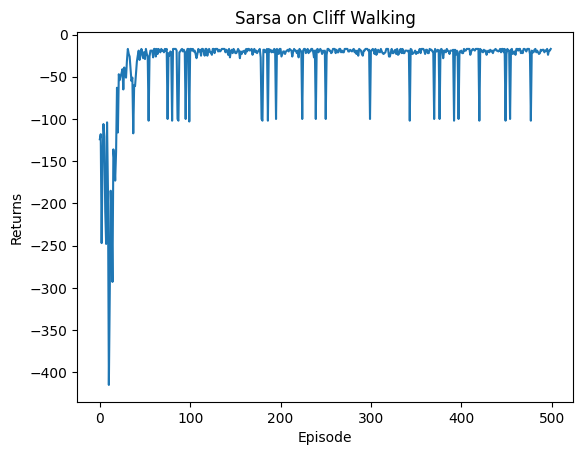

In [124]:
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)): 
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False  
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action 
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode' : '%d' % (num_episodes / 10 * i + i_episode + 1), 'return':'%.3f' % np.mean(return_list[-10])})
            pbar.update(1)
            
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episode')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

In [125]:
action_meaning = ['^', 'v', '<', '>']
print('5 step sarsa algorithm:')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

5 step sarsa algorithm:
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [128]:
class QLearning:
    """Q-Learning Algorithm"""
    def __init__(self, n, nrow, epsilon, alpha, gamma, n_action = 4):
        self.Q_table = np.zeros([nrow * ncol, n_action])    
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon 
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action 
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state][i] == Q_max:
                a[i] = 1
        return a 
    
    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error 
        
        
        

In [129]:
np.random.seed(0)

In [131]:
epsilon = 0.1
alpha = 0.1
gamma = 0.9

In [132]:
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)

In [133]:
num_episodes = 500 

In [134]:
return_list = []

In [135]:
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0 
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode' : '%d' % (num_episodes / 10 * i + i_episode + 1), 'return' : '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)
            


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 6572.08it/s, episode=500, return=-61.700]


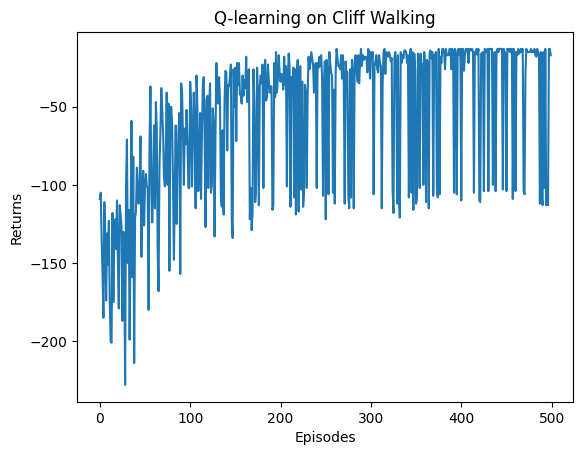

In [136]:
episode_list = list(range(len(return_list)))
plt.plot(episode_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

In [137]:
action_meaning = ['^', 'v', '<', '>']
print('Q learning policy: ')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Q learning policy: 
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [138]:
import random 
import time

In [139]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0 # position of agent
        self.y = self.nrow - 1
        
    def step(self, action):
        # 4 actions: '^', 'v', '<', '>'
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False 
        if self.y == self.nrow - 1 and self.x > 0: # is cliff or target 
            done = True 
            if self.x != self.ncol - 1: # cliff 
                reward = -100 
        return next_state, reward, done 
    
    def reset(self):
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x 
    
    

In [141]:
class DynaQ:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_planning, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action]) 
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning
        self.model = dict()
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action 
    
    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error 
        
    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1 # update data
        for _ in range(self.n_planning):
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)
            
            

In [142]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12 
    nrow = 4 
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300 
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False 
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode' : '%d' % (num_episodes / 10 * i + i_episode + 1), 'return' : '%.3f' % np.mean(return_list[-10:])})
                    pbar.update(1)
    return return_list


Q-planning steps: 0


Iteration 9:  10%|█         | 3/30 [00:00<00:00, 458.11it/s, episode=300, return=-16.500]


Q-planning steps: 2


Iteration 9:  10%|█         | 3/30 [00:00<00:00, 261.62it/s, episode=300, return=-13.500]


Q-planning steps: 20


Iteration 9:  10%|█         | 3/30 [00:00<00:00, 49.66it/s, episode=300, return=-13.400]


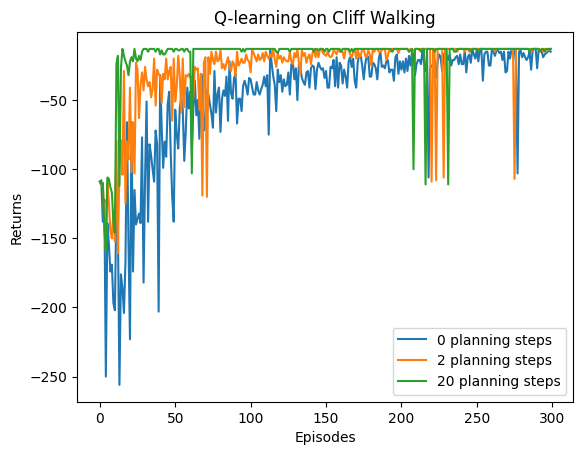

In [143]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning steps: %d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list, return_list, label=str(n_planning) + ' planning steps')
    
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on Cliff Walking')
plt.show()

In [145]:
import gym
import collections
import torch 


In [148]:
import torch.nn.functional as F
import rl_utils
import torch.nn as nn

In [147]:
class ReplayBuffer:
    """put back to buffer"""
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self):
        return len(self.buffer)
    

In [149]:
class Qnet(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    

In [170]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        
        # optimizer
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma 
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device 
        
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action 
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions'])).view(-1, 1).to(self.device) 
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)
        
        q_values = self.q_net(states).gather(1, actions)
        # max_a
        max_next_q_values = self.target_q_net(next_states).max(1)[0].detach()
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad() # reset gradient
        dqn_loss.backward()
        self.optimizer.step()
        
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1
        

In [151]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
min_size = 500
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [153]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [171]:
random.seed(0)

torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n 
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

In [172]:
env.reset()

(array([-0.0055978 , -0.04533034,  0.03549166,  0.04323832], dtype=float32),
 {})

In [173]:
return_list = []

In [179]:
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()[0]
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ , _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                if replay_buffer.size() > min_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states' : b_ns, 'rewards': b_d, 'dones': b_d}
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode' : '%d' % (num_episodes / 10 * i + i_episode + 1), 'return' : '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)
            

Iteration 1:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_63104/630639464.py:34: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
Iteration 9: 100%|██████████| 50/50 [00:03<00:00, 13.62it/s, episode=500, return=19.100]


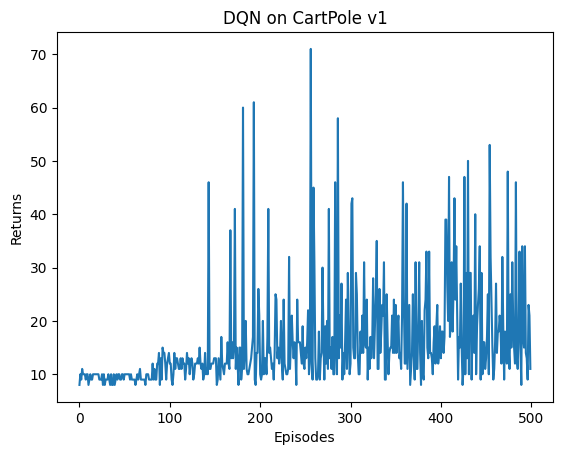

In [180]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on CartPole v1')
plt.show()

In [182]:
mv_return = rl_utils.moving_average(return_list, 9) 

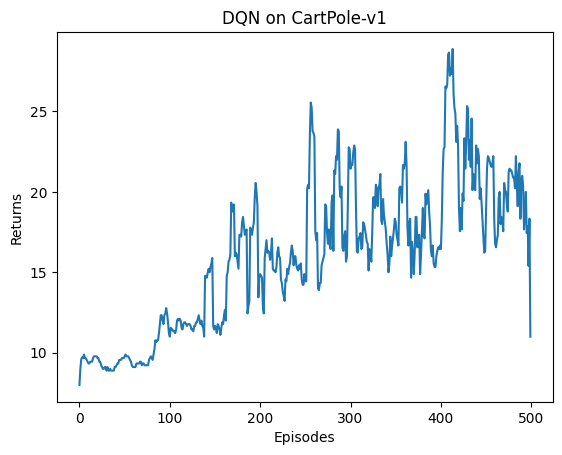

In [183]:
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [213]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
        
    def forward(self, x):
        print('x shape: ', x.shape)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    

In [185]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma 
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device 
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action 
    
    def max_q_value(self, state):
        state = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        q_values = self.q_net(states).gather(1, actions) # Q val
        # Max Q 
        if self.dqn_type == 'DoubleDQN': 
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones) # td errors
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets)) 
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()
        
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [216]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11 

In [217]:
state_dim
action_dim

11

In [187]:
def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]
    action_upperbound = env.action_space.high[0]
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upperbound - action_lowbound)

In [203]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total = int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()[0] # it returns two variables
                print(state)
                done = False 
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.05 + max_q_value * 0.995
                    max_q_value_list.append(max_q_value)
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _  = env.step(action_continuous)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states' : b_s, 'actions' : b_a, 'next_states' : b_ns, 'rewards' : b_r, 'dones' : b_d}
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode' : '%d' % (num_episodes / 10 * i + i_episode + 1), 'return' : '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list, max_q_value_list 


In [193]:
random.seed(0)
np.random.seed(0)
env.reset(seed=0)
torch.manual_seed(0)


In [214]:
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

In [215]:
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

[ 0.3460842   0.93820345 -0.87918645]
x shape:  torch.Size([1, 3])
x shape:  torch.Size([64, 4])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x4 and 3x128)